In [2]:
import numpy as np
from scipy.linalg import eig
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

##------------------------------------
def ev_tau(k,_gd,_tau,_a,_ell_over_W_squared=0.01):
	"""Takes in a set of parameters and returns the spectrum that 
	corresponds to these parameter values.

	Args:
		k (float): wavenumber
		_gammadot (float): external shear rate
		_tau (float): liquid crystal relaxation time
		_tau_a (float): activity time scale

	Returns:
		list[complx numbers]: a (cleaned of any infinities) list of eigenvalues
	"""
	# resolution
	M = 50

	# parameters 
	_llambda = 1.0
	_eta = 1.0
	# _ell_over_W_squared = 0
	_aux_const = 1 + (_gd*_tau)**2
	_tmp_const = k*k*_llambda / _aux_const 


	##------------------------------------
	mode_number = 94 #79
	do_plot_mode = 0

	##------------------------------------

	II = np.identity(M,dtype='d')

	cbar = np.ones(M,dtype='d')
	cbar[0] = 2.0
	cbar[M-1] = 2.0

	# Chebyshev grid points
	ygl = np.zeros(M,dtype='d')
	for m in range(M):
		ygl[m] = np.cos(np.pi*m/(M-1))

	# Build Chebyshev differentiation matrix
	D1 = np.zeros((M,M),dtype='d')
	for l in range(M):
		for j in range(M):
			if l != j:
				D1[l,j] = cbar[l]*((-1)**(l+j))/(cbar[j]*(ygl[l]-ygl[j]))

	for j in range(1,M-1):
		D1[j,j] = -0.5*ygl[j]/(1.0-ygl[j]*ygl[j])

	D1[0,0] = (2.0*(M-1)*(M-1)+1.0)/6.0
	D1[M-1,M-1] = -D1[0,0]

	# The factor 2 takes care of the domain being from -1/2 to 1/2
	D1 = 2*D1

	D2 = np.dot(D1,D1)

	## Auxiliary matrices

	Lmin = D2 - k*k*II 
	Lplus = D2 + k*k*II 


	## LHS

	## Variable layout
	## psi[0:M] Qxx[M:2*M] Qxy[2*M:3*M] 

	Rpsi  = slice(0*M,1*M)
	RQxx  = slice(1*M,2*M)
	RQxy  = slice(2*M,3*M)


	LHS = np.zeros((3*M,3*M),dtype='D')

	# Stokes equation
	LHS[Rpsi, Rpsi] = (k**4*II - 2*(k**2)*D2 + np.dot(D2,D2))/_tau
	LHS[Rpsi,RQxx] = -2j*_a*k*D1/_eta
	LHS[Rpsi, RQxy] = -(_a*(k**2)*II + _a*D2)/_eta

	## Qxx equation
	LHS[RQxx,Rpsi] = (_tmp_const*(_gd*_tau) * II\
							- 2j*k*_llambda*D1 - (_llambda*_gd*_tau/_aux_const)*D2)
	LHS[RQxx,RQxx] = (1 + _ell_over_W_squared*k*k + 1j*k*ygl*_gd*_tau)*II - _ell_over_W_squared*D2
	LHS[RQxx,RQxy] = -_gd*_tau*II

	## Qxy equation
	LHS[RQxy,Rpsi] = (-_tmp_const*(1 + 2*(_gd*_tau)**2)*II)\
							- _llambda / _aux_const * D2
	LHS[RQxy,RQxx] = _gd*_tau*II
	LHS[RQxy,RQxy] = (1 + _ell_over_W_squared*k*k + 1j*k*ygl*_gd*_tau)*II - _ell_over_W_squared*D2

	RHS = np.zeros((3*M,3*M),dtype='D')
	RHS[RQxx,RQxx] = -_tau*II
	RHS[RQxy,RQxy] = -_tau*II

	## Boundary conditions

	LHS[0]     = np.zeros(3*M,dtype='D') # Psi vanishes at the boundaries
	LHS[1]     = np.zeros(3*M,dtype='D') # and dy(Psi) (?) vanishes at the boundaries
	LHS[M-2]   = np.zeros(3*M,dtype='D') # how does this code account for no-slip?
	LHS[M-1]   = np.zeros(3*M,dtype='D')

	LHS[0,0]      = 1.0
	LHS[1,Rpsi]   = D1[0]
	LHS[M-2,Rpsi] = D1[M-1]
	LHS[M-1,M-1]  = 1.0

	LHS[M]     = np.zeros(3*M,dtype='D') # dy(Qxx) vanishes at the boundaries
	LHS[2*M-1] = np.zeros(3*M,dtype='D')

	LHS[M,RQxx]     = D1[0]
	LHS[2*M-1,RQxx] = D1[M-1]

	LHS[2*M]   = np.zeros(3*M,dtype='D') # dy(Qxy) vanishes at the boundaries
	LHS[3*M-1] = np.zeros(3*M,dtype='D')

	LHS[2*M,RQxy]   = D1[0]
	LHS[3*M-1,RQxy] = D1[M-1]


	RHS[0]     = np.zeros(3*M,dtype='D')
	RHS[1]     = np.zeros(3*M,dtype='D')
	RHS[M-2]   = np.zeros(3*M,dtype='D')
	RHS[M-1]   = np.zeros(3*M,dtype='D')
	RHS[M]     = np.zeros(3*M,dtype='D')
	RHS[2*M-1] = np.zeros(3*M,dtype='D')
	RHS[2*M]   = np.zeros(3*M,dtype='D')
	RHS[3*M-1] = np.zeros(3*M,dtype='D')


	_spec = eig(LHS,RHS,left=0,right=1)

	_eig_list = _spec[0]
	_modes_list = _spec[1]

	_clean_eig_list = list(filter(lambda ev: np.isfinite(ev), _eig_list))
	return _clean_eig_list

#print("at k={}, gammadot={}, tau={}, tau_a={}, fastest growth rate:{:.4f} @ freq={:.4f}"\
#.format(k,_gammadot,_tau,_tau_a,np.real(max_val),np.imag(max_val)))
#print("at k={}, tBar={}, aBar={}, fastest growth rate:{:.4f} @ freq={:.4f}"\
#.format(k,_gammadot*_tau,1/(_gammadot*_tau_a),np.real(max_val),np.imag(max_val)))

"""
f=open('spectrum.txt','w')
for i in range(len(_eig_list)):
	if np.isfinite(_eig_list[i]):
	f.write('%20.18f %20.18f\n'%(np.real(_eig_list[i]),np.imag(_eig_list[i]))    )
f.close()

f=open('list.txt','w')
for i in range(len(_eig_list)):
	f.write('%d %20.18f %20.18f\n'%(i,np.real(_eig_list[i]),np.imag(_eig_list[i]))    )    
f.close()
  """


## OUTPUT
"""
_my_mode=_modes_list[:,mode_number]

_psi=_my_mode[0:M]
_Qxx=_my_mode[M:2*M]
_Qxy=_my_mode[2*M:3*M]

if do_plot_mode:

	f=open('psi.field','w')
	for m in range(M):
	f.write('%f %20.18f %20.18f\n'%(ygl[m],np.real(_psi[m]),np.imag(_psi[m])))
	f.close()

	f=open('Qxx.field','w')
	for m in range(M):
	f.write('%f %20.18f %20.18f\n'%(ygl[m],np.real(_Qxx[m]),np.imag(_Qxx[m])))
	f.close()

	f=open('Qxy.field','w')
	for m in range(M):
	f.write('%f %20.18f %20.18f\n'%(ygl[m],np.real(_Qxy[m]),np.imag(_Qxy[m])))
	f.close()
"""

def max_ev_gd_a_grid(_gds,_as,_k,_tau,ell_over_W_sq=0.01):
	gdv, av = np.meshgrid(_gds,_as)

	# N - number of rows (ny), M - number of columns (nx)
	N, M = len(_as), len(_gds)

	evv = np.zeros([N, M])

	for i in range(N):
		for j in range(M):
			gd = gdv[i][j]
			a = av[i][j]
			evv[i][j] = np.max(np.real(ev_tau(_k,gd,_tau,a,_ell_over_W_squared=ell_over_W_sq)))
	return evv

def max_ev_full(_gds,_as,_k,_tau,ell_over_W_sq=0.01):
	gdv, av = np.meshgrid(_gds,_as)

	# N - number of rows (ny), M - number of columns (nx)
	N, M = len(_as), len(_gds)

	evv = np.zeros([N, M])

	for i in range(N):
		for j in range(M):
			gd = gdv[i][j]
			a = av[i][j]
			evv[i][j] = np.max(np.real(ev_tau(_k,gd,_tau,a,_ell_over_W_squared=ell_over_W_sq)))
	return evv

In [3]:
def graph_spectra_gd_a_grid(gd_specs, a_specs, _tau, _k,l_over_W_sq=0.01):
    gdl,gdr,ngd = gd_specs[0],gd_specs[1],gd_specs[2]
    al,ar,na = a_specs[0], a_specs[1], a_specs[2]
    _gds = np.linspace(gdl,gdr,ngd)
    _as = np.linspace(al,ar,na)
    gdv, av = np.meshgrid(_gds, _as)
    
    mat = np.zeros([na,ngd])
    mat = max_ev_gd_a_grid(_gds,_as,_k,_tau,ell_over_W_sq=l_over_W_sq)
    for i in range(na):
        for j in range(ngd):
            c = "red" if mat[i][j] > 0 else "blue"
            plt.plot(gdv[i][j],av[i][j],".",color=c, picker=True)
    plt.xlabel("$\dot\gamma$")
    plt.ylabel("$a$")
    blue_dot = mlines.Line2D([], [], color='blue', marker='.', linestyle='None',
                          markersize=10, label='stable')
    red_dot = mlines.Line2D([], [], color='red', marker='.', linestyle='None',
                          markersize=10, label='unstable')
    plt.legend(handles=[blue_dot, red_dot])
    plt.title("Stability Plot in the $\dot\gamma$-$a$ plane, $k$={}".format(_k))
    plt.show()

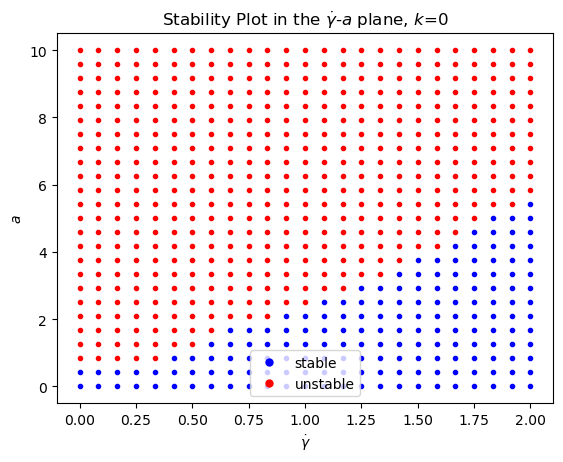

In [2]:
"""THIS CODE BLOCK IS USED FOR TESTING"""
# parameters
tau, k = 1, 0
gdl, gdr, ngd = 0,2,25
al, ar, na = 0,10,25
   
# make stability plot
graph_spectra_gd_a_grid([gdl,gdr,ngd],[al,ar,na],tau,k)

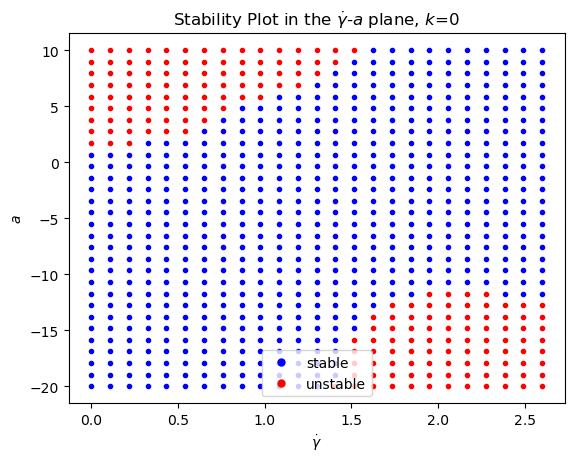

In [26]:
"""NEGATIVE ACTIVITY VALUES"""
# parameters
tau, k = 1, 0
gdl, gdr, ngd = 0,2.6,25
al, ar, na = -20,10,30
   
# make stability plot
graph_spectra_gd_a_grid([gdl,gdr,ngd],[al,ar,na],tau,k)

### ^Compared to the 1D flow case, the critical activity for 2D contractile flow is more negative.

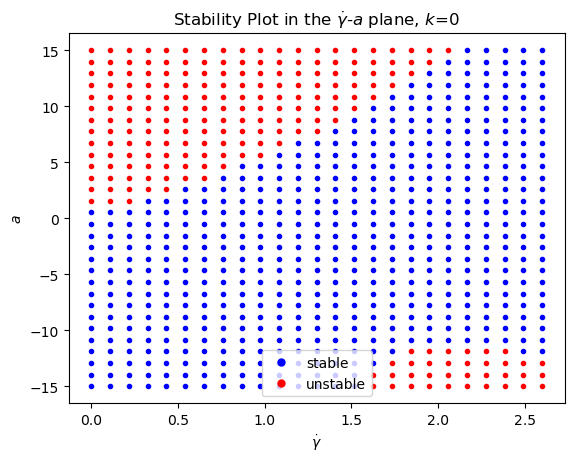

In [27]:
"""ZERO k & ZERO l"""
# parameters
tau, k = 1, 0
gdl, gdr, ngd = 0,2.6,25
al, ar, na = -15,15,30
   
# make stability plot
graph_spectra_gd_a_grid([gdl,gdr,ngd],[al,ar,na],tau,k,l_over_W_sq=0.01)

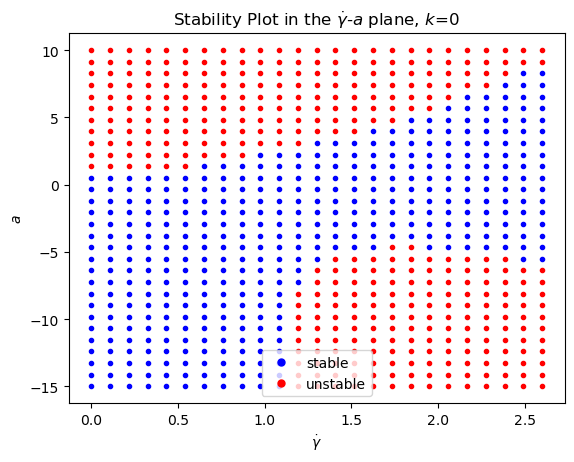

In [24]:
"VERIFYING ZERO k AND l ANALYTIC SOLUTION"
# parameters
tau, k = 1, 0
gdl, gdr, ngd = 0,2.6,25
al, ar, na = -15,10,30
   
# make stability plot
graph_spectra_gd_a_grid([gdl,gdr,ngd],[al,ar,na],tau,k,l_over_W_sq=0)

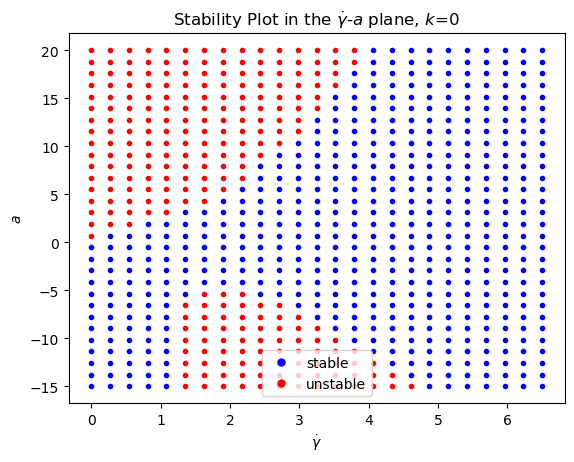

In [18]:
"VERIFYING ZERO k AND l ANALYTIC SOLUTION"
# parameters
tau, k = 1, 0
gdl, gdr, ngd = 0,6.5,25
al, ar, na = -15,20,30
   
# make stability plot
graph_spectra_gd_a_grid([gdl,gdr,ngd],[al,ar,na],tau,k,l_over_W_sq=0)

In [12]:
# parameters
tau, k = 1, 0
gdl, gdr, ngd = 0,6.5,25
al, ar, na = -15,20,30
_gds = np.linspace(gdl,gdr,ngd)
_as = np.linspace(al,ar,na)
gdv, av = np.meshgrid(_gds,_as)

# compute stability, save the numbers to file
evs = max_ev_gd_a_grid(_gds,_as,k,tau,ell_over_W_sq=0)
np.savetxt("data/ev-data-1", evs, delimiter=',')
np.savetxt("data/gdv-1", gdv, delimiter=',')
np.savetxt("data/av-1", av, delimiter=',')

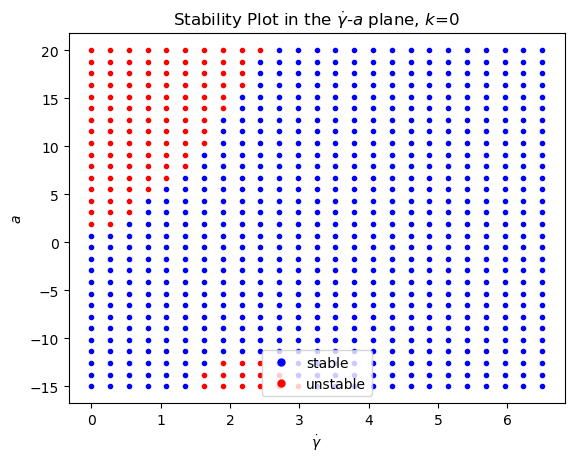

In [19]:
"More shear values at non-zero l"
# parameters
tau, k = 1, 0
gdl, gdr, ngd = 0,6.5,25
al, ar, na = -15,20,30
   
# make stability plot
graph_spectra_gd_a_grid([gdl,gdr,ngd],[al,ar,na],tau,k,l_over_W_sq=0.01)

# Observe asymptotic behavior for contractile flows

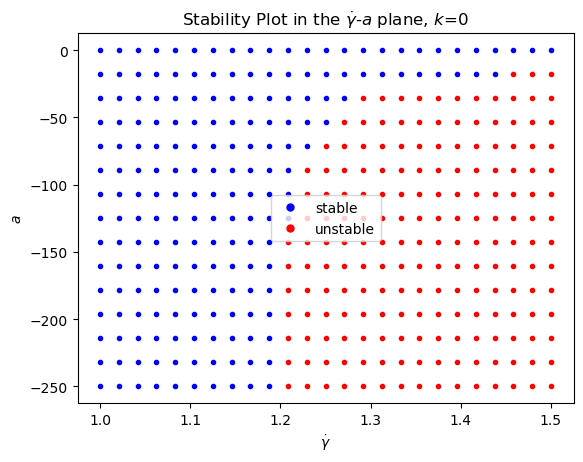

In [25]:
"ASYMPTOTIC NEGATIVE ACTIVITY BEHAVIOR?"
# parameters
tau, k = 1, 0
gdl, gdr, ngd = 1.0,1.5,25
al, ar, na = -250,0,15
   
# make stability plot
graph_spectra_gd_a_grid([gdl,gdr,ngd],[al,ar,na],tau,k,l_over_W_sq=0.01)

# The case for $k=l=0$ agrees with analytic solution with critical shear at $\dot\gamma = 1$

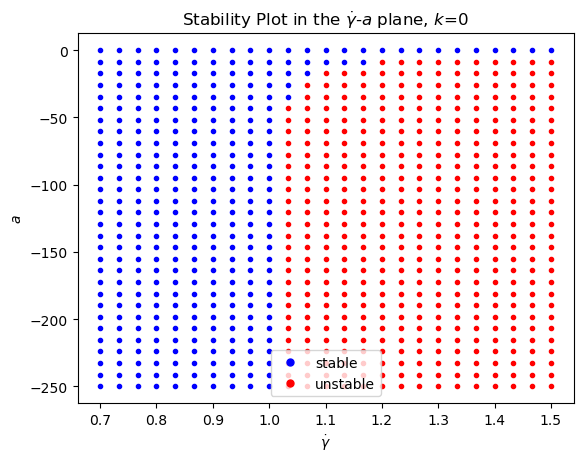

In [21]:
"ASYMPTOTIC NEGATIVE ACTIVITY BEHAVIOR for l=0"
# parameters
tau, k = 1, 0
gdl, gdr, ngd = 0.7,1.5,25
al, ar, na = -250,0,30
   
# make stability plot
graph_spectra_gd_a_grid([gdl,gdr,ngd],[al,ar,na],tau,k,l_over_W_sq=0)

In [6]:
def max_re(zs):
    acc = -float('inf')
    for z in zs:
        if z.real > acc:
            acc = z
    return acc

def plot_resig_k(_a, _gds, n=20, plot=True,k_left=0, k_right =20):
    _tau = 1
    ks = np.linspace(k_left,k_right,n)
    max_real_evs = np.zeros((len(_gds),n),dtype=np.complex_)
    for j in range(len(_gds)):
        for i in range(len(ks)):
            evs = ev_tau(ks[i],_gds[j],_tau,_a,_ell_over_W_squared=0.01)
            max_real_evs[j][i] = max_re(evs)
    if plot:
        for row in range(len(max_real_evs)):
            plt.plot(ks, np.real(max_real_evs[row]),label="$\dot\gamma = {}$".format(_gds[row]))
        plt.legend(loc="upper right")
        plt.axhline(y=0,linestyle=':')
        plt.title("$Re(\sigma)$ vs. $k$, a={}".format(_a))
        plt.xlabel("$k$")
        plt.ylabel("$Re(\sigma)$")
    return max_real_evs

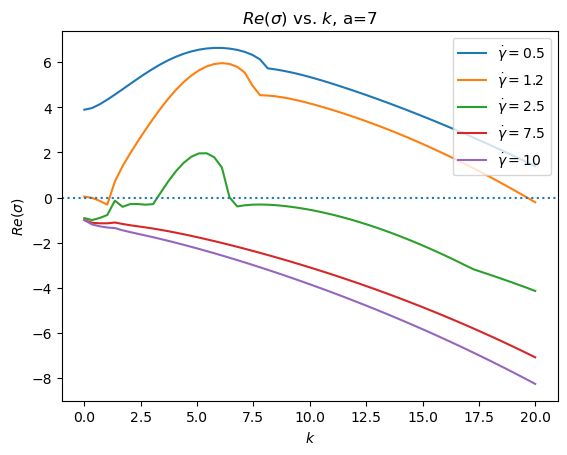

In [7]:
_a=7
_gds = [0.5, 1.2, 2.5, 7.5, 10]
max_real_evs_test = plot_resig_k(_a,_gds, n=60)

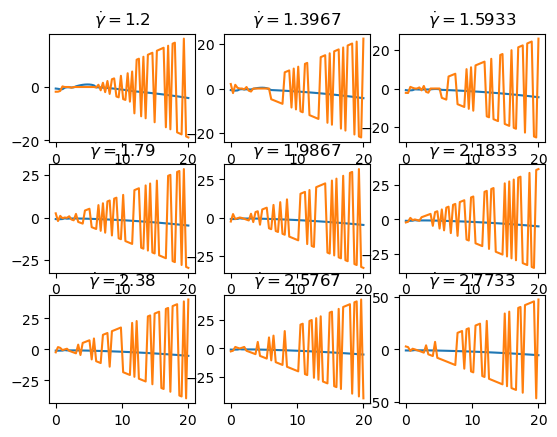

In [186]:
ks = np.linspace(0,20,60)
#define grid of plots
fig, axs = plt.subplots(nrows=3, ncols=3)
for i in range(3):
    for j in range(3):
        axs[i][j].set_title("$\dot\gamma=${}".format(round(_gds[3*i+j],4)))
        axs[i][j].plot(ks,np.real(max_real_evs_test[3*i + j]), label="real")
        axs[i][j].plot(ks,np.imag(max_real_evs_test[3*i + j]), label="imag")

# ^^ Observation: The oscillation of the imaginary part of $\sigma$ seems to correlate with the location of the bump!

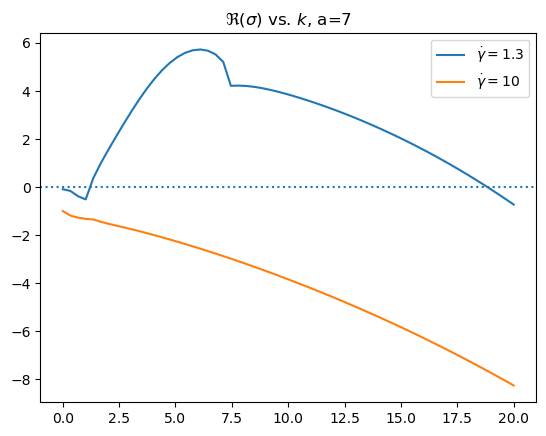

In [192]:
_a=7
_gds = [1.3, 10]
max_real_evs_test = plot_resig_k(_a,_gds, n=60, plot=True)

In [251]:
_gds=[1.3]
_a=7
evska7_1 = plot_resig_k(_a, _gds, n=200, plot=False,k_left=0, k_right =9)

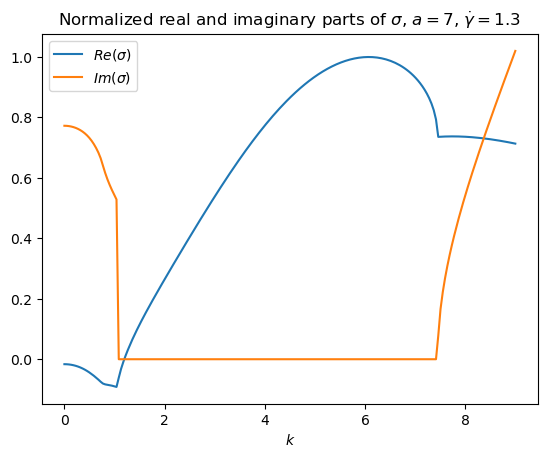

In [255]:
ks = np.linspace(0,9,200)
# take absolute value of the imaginary parts because conjugate pairs!
plt.plot(ks,np.real(evska7_1[0]) / np.abs(np.max(np.real(evska7_1[0]))), label="$Re(\sigma)$")
plt.plot(ks,np.abs(np.imag(evska7_1[0])) / np.abs(np.max(np.imag(evska7_1[0]))), label="$Im(\sigma)$")
plt.title("Normalized real and imaginary parts of $\sigma$, $a=${}, $\dot\gamma=${}".format(7,1.3))
plt.xlabel("$k$")
plt.legend()

In [16]:
_gds=[1.3]
_a=2
evska7_1 = plot_resig_k(_a, _gds, n=200, plot=False,k_left=0, k_right =9)

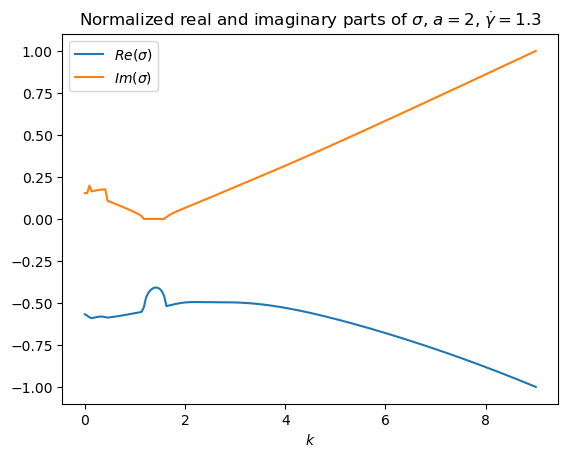

In [18]:
ks = np.linspace(0,9,200)
# take absolute value of the imaginary parts because conjugate pairs!
plt.plot(ks,np.real(evska7_1[0]) / np.abs(np.min(np.real(evska7_1[0]))), label="$Re(\sigma)$")
plt.plot(ks,np.abs(np.imag(evska7_1[0])) / np.abs(np.max(np.imag(evska7_1[0]))), label="$Im(\sigma)$")
plt.title("Normalized real and imaginary parts of $\sigma$, $a=${}, $\dot\gamma=${}".format(_a,_gds[0]))
plt.xlabel("$k$")
plt.legend()

In [253]:
_gds=[10]
_a=7
evska7_2 = plot_resig_k(_a, _gds, n=200, plot=False,k_left=0, k_right =9)

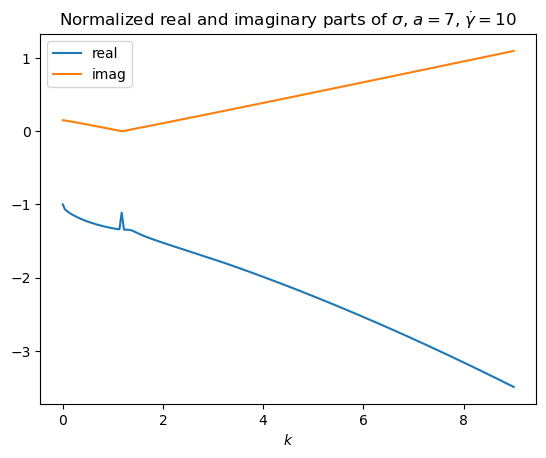

In [256]:
ks = np.linspace(0,9,200)
#define grid of plots
plt.plot(ks,np.real(evska7_2[0]), label="real")
plt.plot(ks,np.abs(np.imag(evska7_2[0])) / np.abs(np.max(np.imag(evska7_2[0]))), label="imag")
plt.title("Normalized real and imaginary parts of $\sigma$, $a=${}, $\dot\gamma=${}".format(7,10))
plt.xlabel("$k$")
plt.legend()

## ^^ Let $\sigma = \sigma_R + \sqrt{\sigma_I}$, we can conlude that $\sigma_I$ is probably some concave function that depends on $\dot\gamma, a,$ and $k$. Increasing $\dot\gamma$ shifts $\sigma_I$ down, and increasing $a$ shifts $\sigma_I$ up.

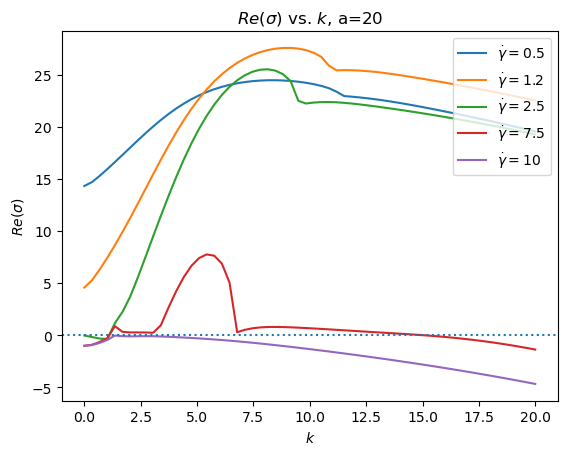

In [19]:
_a=20
_gds = [0.5, 1.2, 2.5, 7.5, 10]
max_real_evs_test = plot_resig_k(_a,_gds, n=60)

## Observation: Depending on the value of $a$, there is a region of non-analyticity for a range of $\dot\gamma$'s where $\text{Re}(\sigma)$ increases with $k$. Past a critical value of $\dot\gamma$, we can safely conclude that if $\text{Re}(\sigma)<0$ when $k=0$, then it will be negative for all $k>0$. This does not happen in any case for $\dot\gamma =0$. Where is this weird behavior in $k$ coming from?

### Answer: imaginary part of $\sigma$!

In [75]:
def is_stable(gd,a,tau=1):
    ks = np.linspace(0,30,30)
    for i in range(len(ks)):
        evs = ev_tau(ks[i],gd,tau,a)
        if np.max(np.real(evs)) > 0:
            return 0
    return 1

[is_stable(1,5), is_stable(8,2), is_stable(10,2)]

[0, 1, 1]

In [88]:
al, ar, an = -3, 3, 6
gdl, gdr, gdn = 0, 6, 6
acts = np.linspace(al,ar,an)
gds = np.linspace(gdl, gdr, gdn)
gdv, av = np.meshgrid(gds,acts)
n,m = len(gdv), len(gdv[0])
stable_mat = np.zeros((n,m))
for i in range(n):
    for j in range(m):
        stable_mat[i][j] = is_stable(gdv[i][j], av[i][j])
np.savetxt("data/scan-stability-data-gd", gdv, delimiter=',')
np.savetxt("data/scan-stability-data-a", av, delimiter=',')
np.savetxt("data/scan-stability-data-stability", stable_mat, delimiter=',')

In [3]:
def max_re(zs):
    acc = -float('inf')
    for z in zs:
        if z.real > acc:
            acc = z
    return acc

def compute_sig_k(_a, _gds, n=20, plot=False,k_left=0, k_right =20):
    """ 
    Fixes a, compute sigma(k) for all given shear rates
    """
    _tau = 1
    ks = np.linspace(k_left,k_right,n)
    max_real_evs = np.zeros((len(_gds),n),dtype=np.complex_)
    for j in range(len(_gds)):
        for i in range(len(ks)):
            evs = ev_tau(ks[i],_gds[j],_tau,_a,_ell_over_W_squared=0.01)
            max_real_evs[j][i] = max_re(evs)
        if plot:
            plt.plot(ks, max_real_evs[j], label="$\dot\gamma={}$".format(_gds[j]))
    if plot:
        plt.plot(ks, np.zeros(len(ks)), "--")
    return max_real_evs

In [3]:
gdl, gdr, gdn = 0,6.5,25
al, ar, an = -15,20,30
_gds = np.linspace(gdl,gdr,gdn)
_as = np.linspace(al,ar,an)
for i in range(len(_as)):
    evs_mat = compute_sig_k(_as[i],_gds)
    print("{}/{} iterations completed".format(i+1, len(_as)))
    np.savetxt("data/k-scan/a_{}".format(i), evs_mat, delimiter=',')
    # use np.loadtxt("data/k-scan/a_0", dtype=np.complex_, delimiter=",") to load data in

1/30 iterations completed
2/30 iterations completed
3/30 iterations completed
4/30 iterations completed
5/30 iterations completed
6/30 iterations completed
7/30 iterations completed
8/30 iterations completed
9/30 iterations completed
10/30 iterations completed
11/30 iterations completed
12/30 iterations completed
13/30 iterations completed
14/30 iterations completed
15/30 iterations completed
16/30 iterations completed
17/30 iterations completed
18/30 iterations completed
19/30 iterations completed
20/30 iterations completed
21/30 iterations completed
22/30 iterations completed
23/30 iterations completed
24/30 iterations completed
25/30 iterations completed
26/30 iterations completed
27/30 iterations completed
28/30 iterations completed
29/30 iterations completed
30/30 iterations completed


In [5]:
# zoom in on the extensile region to compare with Wan's code
gdl, gdr, gdn = 0,1,11
al, ar, an = -15,15,25
_gds = np.linspace(gdl,gdr,gdn)
_as = np.linspace(al,ar,an)
for i in range(len(_as)):
    evs_mat = compute_sig_k(_as[i],_gds)
    print("{}/{} iterations completed".format(i+1, len(_as)))
    np.savetxt("data/k-scan-ext-zoom/a_{}".format(i), evs_mat, delimiter=',')
    # use np.loadtxt("data/k-scan/a_0", dtype=np.complex_, delimiter=",") to load data in

1/25 iterations completed
2/25 iterations completed
3/25 iterations completed
4/25 iterations completed
5/25 iterations completed
6/25 iterations completed
7/25 iterations completed
8/25 iterations completed
9/25 iterations completed
10/25 iterations completed
11/25 iterations completed
12/25 iterations completed
13/25 iterations completed
14/25 iterations completed
15/25 iterations completed
16/25 iterations completed
17/25 iterations completed
18/25 iterations completed
19/25 iterations completed
20/25 iterations completed
21/25 iterations completed
22/25 iterations completed
23/25 iterations completed
24/25 iterations completed
25/25 iterations completed


Text(0, 0.5, 'Re$(\\sigma)$')

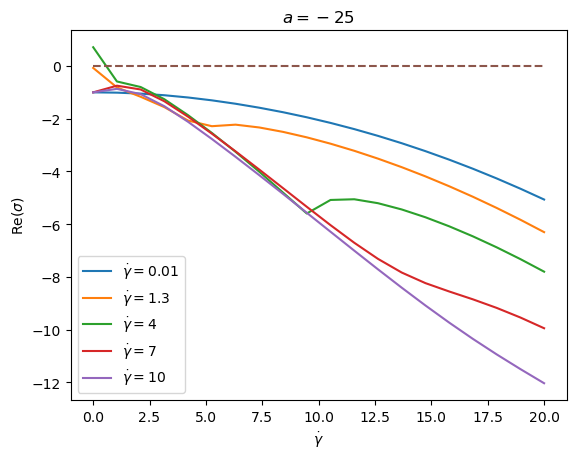

In [57]:
gdl, gdr, gdn = 0,6.5,25
al, ar, an = -15,20,30
_gds = np.linspace(gdl,gdr,gdn)
_as = np.linspace(al,ar,an)
mat = compute_sig_k(-25, [0.01, 1.3, 4, 7, 10], plot=True)
plt.legend()
plt.title("$a=-25$")
plt.xlabel("$\dot\gamma$")
plt.ylabel("Re$(\sigma)$")
# for row in test_mat:
#     plt.plot(np.linspace(0,20,20), np.real(row))

Text(0, 0.5, 'Re$(\\sigma)$')

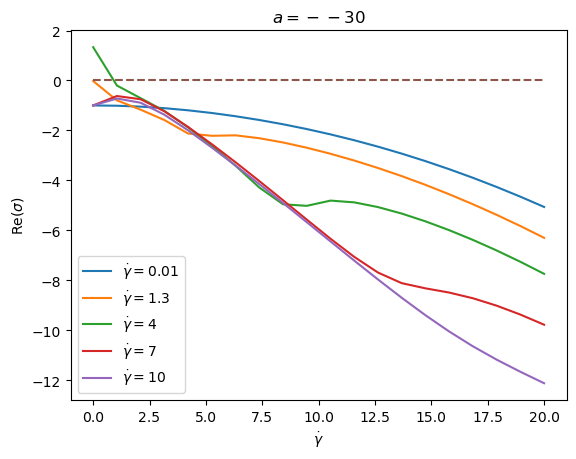

In [58]:
gdl, gdr, gdn = 0,6.5,25
a=-30
_gds = np.linspace(gdl,gdr,gdn)
mat = compute_sig_k(a, [0.01, 1.3, 4, 7, 10], plot=True)
plt.legend()
plt.title("$a=-{}$".format(a))
plt.xlabel("$\dot\gamma$")
plt.ylabel("Re$(\sigma)$")

Text(0, 0.5, 'Re$(\\sigma)$')

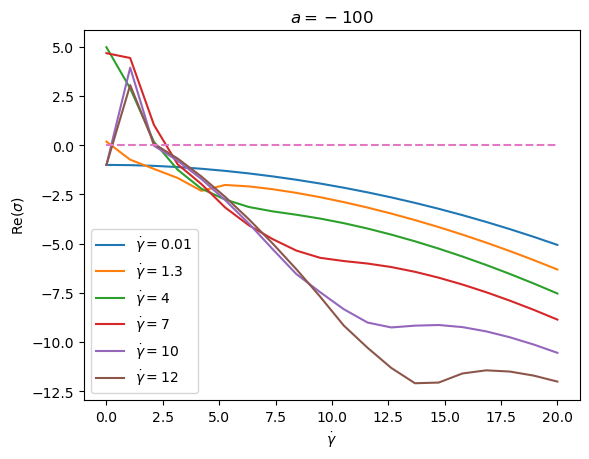

In [63]:
gdl, gdr, gdn = 0,6.5,25
a=-100
_gds = np.linspace(gdl,gdr,gdn)
mat = compute_sig_k(a, [0.01, 1.3, 4, 7, 10, 12], plot=True)
plt.legend()
plt.title("$a={}$".format(a))
plt.xlabel("$\dot\gamma$")
plt.ylabel("Re$(\sigma)$")

Text(0, 0.5, 'Re$(\\sigma)$')

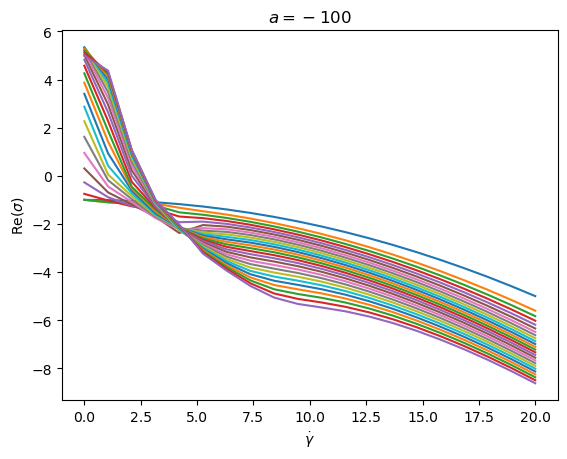

In [65]:
gdl, gdr, gdn = 0,6.5,25
a=-100
_gds = np.linspace(gdl,gdr,gdn)
mat = compute_sig_k(a, _gds, plot=True)
plt.title("$a={}$".format(a))
plt.xlabel("$\dot\gamma$")
plt.ylabel("Re$(\sigma)$")